In [1]:
import pandas as pd
%pylab inline
import requests,json
matplotlib.rcParams['font.family'] = ['STHeiti']
mpl.rcParams['font.size'] = 16.0

Populating the interactive namespace from numpy and matplotlib


In [9]:
# load cumulated percentages from previous analysis
# and remove outdated confirmed cases and dead cases stats
traffic_table = pd.read_csv("data/confirm_vs_traffic.csv").drop(columns=['confirm','dead'])
traffic_table.head()

,city,percentage
0,孝感,13.243244
1,黄冈,12.489446
2,荆州,6.255026
3,咸宁,5.075959
4,鄂州,4.291578


In [10]:
# update the confirmed number with the latest data
res = requests.get("https://service-0gg71fu4-1252957949.gz.apigw.tencentcs.com/release/dingxiangyuan")
res = res.text
res = json.loads(res)

In [4]:
res

{'errorCode': 0,
 'errorMessage': '',
 'ok': True,
 'data': {'getListByCountryTypeService2': [{'id': 953,
    'createTime': 1580027704000,
    'modifyTime': 1580561200000,
    'tags': '',
    'countryType': 2,
    'continents': '亚洲',
    'provinceId': '6',
    'provinceName': '日本',
    'provinceShortName': '',
    'cityName': '',
    'confirmedCount': 20,
    'suspectedCount': 0,
    'curedCount': 1,
    'deadCount': 0,
    'comment': '',
    'sort': 0,
    'operator': 'xuyt',
    'locationId': 951002},
   {'id': 949,
    'createTime': 1580027637000,
    'modifyTime': 1580495765000,
    'tags': '',
    'countryType': 2,
    'continents': '亚洲',
    'provinceId': '2',
    'provinceName': '泰国',
    'provinceShortName': '',
    'cityName': '',
    'confirmedCount': 19,
    'suspectedCount': 0,
    'curedCount': 5,
    'deadCount': 0,
    'comment': '',
    'sort': 0,
    'operator': 'xuyt',
    'locationId': 952010},
   {'id': 950,
    'createTime': 1580027655000,
    'modifyTime': 1580619

In [11]:
assert res['ok'] == True

case_list = []
stats = res['data']['getAreaStat']
for prov in stats:
    for city in prov['cities']:
        name = city['cityName']
        # 与百度迁移命名一致
        if name == "恩施土家族苗族自治州":
            name = "恩施州'"
        case_list.append({
            'city': name,
            'confirm': city['confirmedCount'],
            'cure': city['curedCount'],
            'dead': city['deadCount'],
            'province': prov['provinceName']
        })
    # 加入直辖市到城市一级
    if prov['provinceShortName'] in ["重庆", "北京", "上海", "天津"]:
        case_list.append({
            'city': prov['provinceShortName'],
            'confirm': prov['confirmedCount'],
            'cure': prov['curedCount'],
            'dead': prov['deadCount'],
            'province': prov['provinceName']
        })
case_table = pd.DataFrame(case_list)
case_table.head()

,city,confirm,cure,dead,province
0,武汉,8351,371,362,湖北省
1,黄冈,1645,52,25,湖北省
2,孝感,1462,6,18,湖北省
3,襄阳,735,7,2,湖北省
4,荆州,713,10,9,湖北省


In [12]:
# match the percentage values
combine_df = pd.merge(left=traffic_table,right=case_table,left_on='city',right_on='city')
combine_df.head()

,city,percentage,confirm,cure,dead,province
0,孝感,13.243244,1462,6,18,湖北省
1,黄冈,12.489446,1645,52,25,湖北省
2,荆州,6.255026,713,10,9,湖北省
3,咸宁,5.075959,384,2,0,湖北省
4,鄂州,4.291578,382,6,18,湖北省


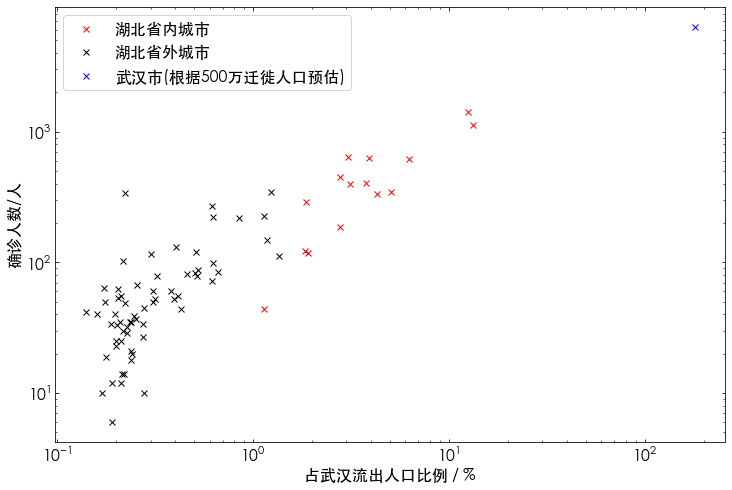

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
in_hubei = combine_df.province == '湖北省'
plt.plot(combine_df.percentage[in_hubei], combine_df.confirm[in_hubei], 'rx', label='湖北省内城市')
plt.plot(combine_df.percentage[~in_hubei], combine_df.confirm[~in_hubei], 'kx', label='湖北省外城市')
plt.plot((1400-500)/500*100, 6384, 'bx', label='武汉市(根据500万迁徙人口预估)')
plt.xlabel("占武汉流出人口比例 / %", fontsize=16)
plt.ylabel("确诊人数/人",fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## 饼状图

In [21]:
combine_df.to_csv("data/case_migration_0202.csv")

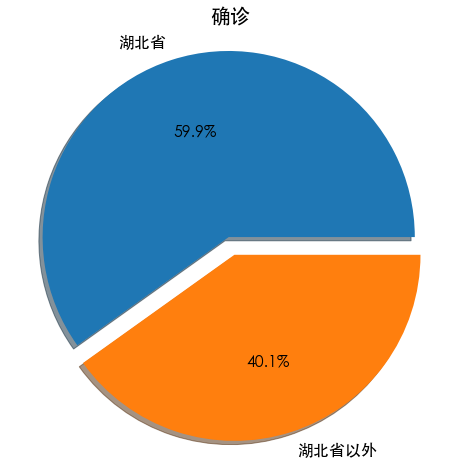

In [28]:
total_confirm = case_table.confirm.sum()
hubei_confirm = case_table[case_table['province']=="湖北省"].confirm.sum()
total_confirm_ex_hb = case_table[case_table['province']!="湖北省"].confirm.sum()

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '湖北省', '湖北省以外'
sizes=[hubei_confirm, total_confirm_ex_hb]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('确诊',fontsize=20)
plt.show()


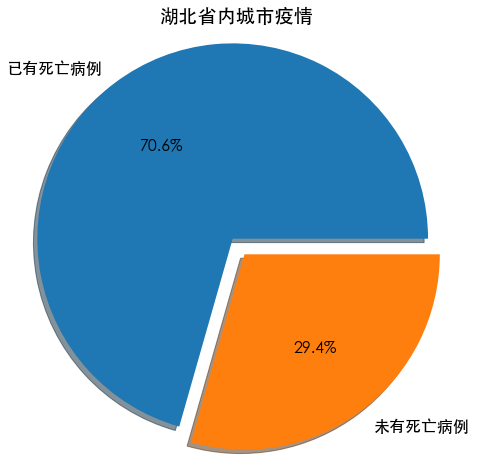

In [32]:
traffic = case_table[case_table.province=='湖北省']

dead_cities_num = traffic[traffic['dead']!=0].city.count().astype('int64')
total_infected_cities_num=traffic['confirm'].count().astype('int64')

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '已有死亡病例', '未有死亡病例'
sizes=[dead_cities_num, total_infected_cities_num-dead_cities_num]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('湖北省内城市疫情')
plt.show()

## 确诊病例/万武汉迁移人口

假设武汉1-26日总迁出人口为500万人

Text(0.5, 1.0, '1/1-1/26 各个城市从武汉迁入人数与病例对比')

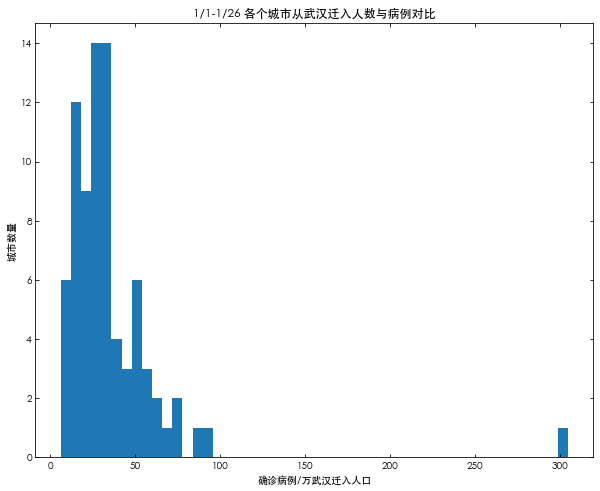

In [9]:
df = combine_df[combine_df.city != '武汉']
plt.figure(figsize=(10,8))
plt.hist(df.confirm / (df.percentage/100 * 500),bins=50)
plt.xlabel("确诊病例/万武汉迁入人口")
plt.ylabel("城市数量")
plt.title("1/1-1/26 各个城市从武汉迁入人数与病例对比")

Text(0.5, 1.0, '1/1-1/26 各个城市从武汉迁入人数与病例对比')

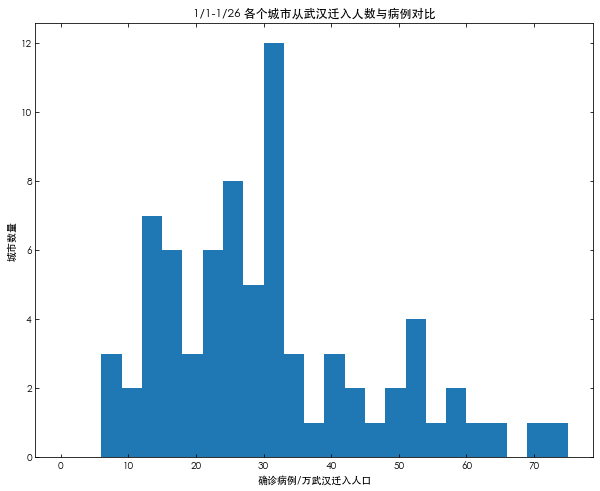

In [10]:
df = combine_df[combine_df.city != '武汉']
plt.figure(figsize=(10,8))
plt.hist(df.confirm / (df.percentage/100 * 500),bins=np.linspace(0,75,26))
plt.xlabel("确诊病例/万武汉迁入人口")
plt.ylabel("城市数量")
plt.title("1/1-1/26 各个城市从武汉迁入人数与病例对比")

Text(0.5, 1.0, '1/1-1/26 各个城市从武汉迁入人数与病例对比')

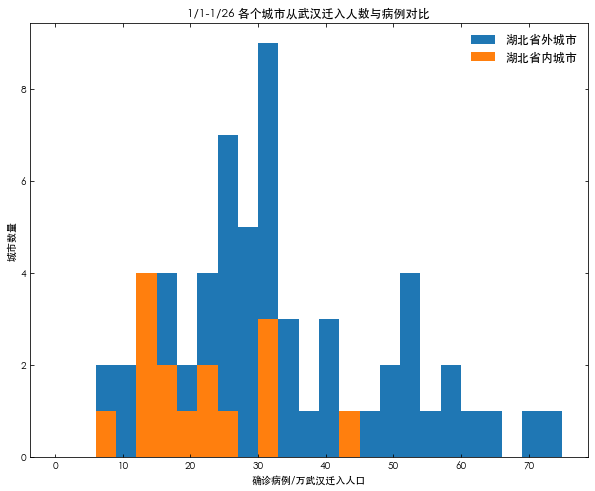

In [11]:
df = combine_df[combine_df.province != '湖北省']
plt.figure(figsize=(10,8))
plt.hist(df.confirm / (df.percentage/100 * 500),bins=np.linspace(0,75,26), label="湖北省外城市")
df = combine_df[combine_df.province == '湖北省']
plt.hist(df.confirm / (df.percentage/100 * 500),bins=np.linspace(0,75,26), label="湖北省内城市")
plt.xlabel("确诊病例/万武汉迁入人口")
plt.ylabel("城市数量")
plt.legend(frameon=False)
plt.title("1/1-1/26 各个城市从武汉迁入人数与病例对比")

In [26]:
combine_df['confirm_per_10000'] = combine_df.confirm / (combine_df.percentage/100 * 500) 

In [42]:
# 读取人均GDP数据
gdp_table = pd.read_csv("data/gdp_per_capita.csv",thousands=',')
gdp_table.head()

,Unnamed: 0,city,province,gdp_pc_cny,gdp_pc_us,rank,year
0,0,石家庄,河北省[注 3],51043,8195,123,2015
1,1,唐山,河北省,78398,12587,43,2015
2,2,秦皇岛,河北省,40746,6542,163,2015
3,3,邯郸,河北省,33450,5371,202,2015
4,4,邢台,河北省,24256,3894,286,2015


In [18]:
df_w_gdp = pd.merge(left=combine_df,right=gdp_table,left_on='city',right_on='city') 

Text(0.5, 1.0, '各城市致死率与人均GDP对比')

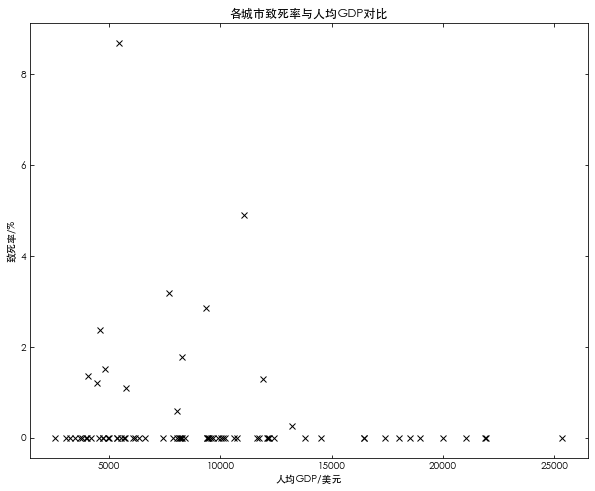

In [19]:
plt.figure(figsize=(10,8))
# plt.plot(df_w_gdp.gdp_pc_us, df_w_gdp.confirm_per_10000, 'kx')
plt.plot(df_w_gdp.gdp_pc_us, df_w_gdp.dead / df_w_gdp.confirm * 100, 'kx')
# plt.ylim([0.01,0.8])
plt.xlabel("人均GDP/美元")
plt.ylabel("致死率/%")
plt.title("各城市致死率与人均GDP对比")

In [20]:
df_w_gdp.to_csv("data/cases_with_gdp.csv",index=False)

## 医院数量

In [39]:
hospital_table = pd.read_csv("../hospital.csv")
for i, r in hospital_table.iterrows():
    if r.city[-1] == '市':
        hospital_table.loc[i,'city'] = r.city[:-1]
hospital_table.head()

,city,city_en,n_hospital,n_hospital_in_city,n_bed,n_bed_in_city,n_doctor,n_doctor_in_city
0,北京,Beijing,713.0,713.0,110021.0,110021.0,89411.0,89411.0
1,天津,Tianjin,571.0,571.0,61764.0,61764.0,37804.0,36088.0
2,河北省,Hebei,NaN,NaN,NaN,NaN,NaN,NaN
3,石家庄,Shijiazhuang,425.0,66.0,49573.0,5602.0,31781.0,3058.0
4,唐山,Tangshan,351.0,152.0,38587.0,21544.0,18737.0,10754.0


In [30]:
df_w_hospital = pd.merge(left=combine_df,right=hospital_table,left_on='city',right_on='city') 
df_w_hospital

,city,percentage,confirm,cure,dead,province,confirm_per_10000,city_en,n_hospital,n_hospital_in_city,n_bed,n_bed_in_city,n_doctor,n_doctor_in_city
0,孝感,13.243244,918,2,14,湖北省,13.863673,Xiaogan,159.0,32.0,18856.0,5228.0,8485.0,2064.0
1,黄冈,12.489446,1246,32,17,湖北省,19.952847,Huanggang,286.0,22.0,34031.0,3980.0,12859.0,1451.0
2,荆州,6.255026,499,6,6,湖北省,15.955171,Jingzhou,182.0,45.0,26751.0,9791.0,12695.0,4370.0
3,咸宁,5.075959,296,1,0,湖北省,11.662820,Xianning,95.0,21.0,13716.0,4371.0,6720.0,1735.0
4,鄂州,4.291578,306,2,15,湖北省,14.260489,Ezhou,489.0,489.0,5804.0,5804.0,2191.0,2191.0
5,襄阳,3.919618,548,1,0,湖北省,27.961909,Xiangyang,221.0,85.0,32107.0,13836.0,13234.0,7263.0
6,黄石,3.777272,334,8,2,湖北省,17.684720,Huangshi,71.0,43.0,15400.0,8831.0,5334.0,3079.0
7,荆门,3.132421,345,6,11,湖北省,22.027693,Jingmen,111.0,30.0,15743.0,6934.0,7278.0,2678.0
8,荆门,3.132421,345,6,11,湖北省,22.027693,NaN,NaN,58.0,NaN,NaN,NaN,NaN
9,随州,3.039212,458,3,5,湖北省,30.139389,Suizhou,106.0,47.0,10431.0,4801.0,4218.0,1849.0


Text(0, 0.5, '致死率/%')

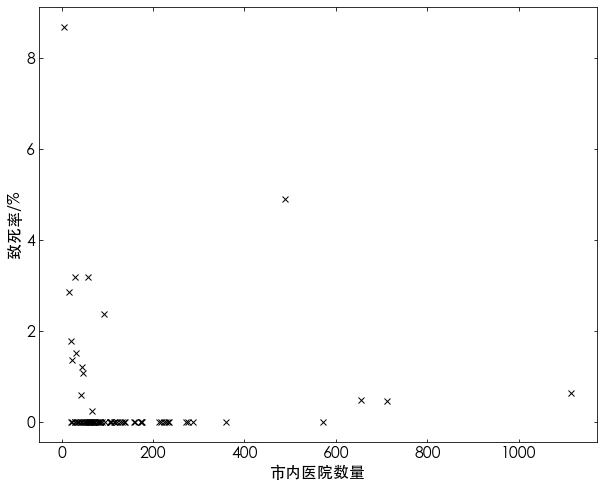

In [36]:
plt.figure(figsize=(10,8))
plt.plot(df_w_hospital.n_hospital_in_city, df_w_hospital.dead/df_w_hospital.confirm*100,'kx')
plt.xlabel("市内医院数量")
plt.ylabel("致死率/%")

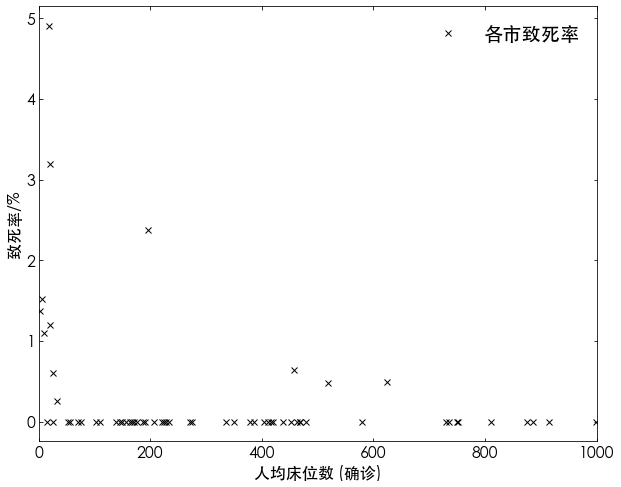

In [80]:
plt.figure(figsize=(10,8))
plt.plot(df_w_hospital.n_bed_in_city/df_w_hospital.confirm, df_w_hospital.dead/df_w_hospital.confirm*100,'kx',label='各市致死率')
plt.xlabel("人均床位数 (确诊)")
plt.ylabel("致死率/%")
plt.xlim([0,1000])
plt.legend(frameon=False) 
 
# plt.xscale('log')

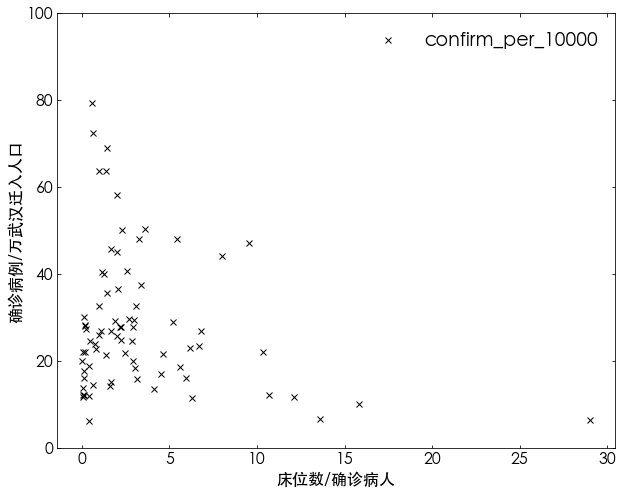

In [79]:
plt.figure(figsize=(10,8))
# plt.plot(df_w_hospital.n_bed_in_city/df_w_hospital.confirm, df_w_hospital.confirm_per_10000,'kx')
plt.plot(df_w_hospital.n_hospital_in_city/df_w_hospital.confirm, df_w_hospital.confirm_per_10000,'kx')
plt.xlabel("床位数/确诊病人")
plt.ylabel("确诊病例/万武汉迁入人口")
# plt.xlim([0,1000])
# plt.xscale('log')
plt.ylim([0,100])
plt.legend(frameon=False)

In [87]:
from scipy import stats
df = df_w_hospital.dropna()
n_bed_per_confirm = np.array(df.n_bed_in_city/df.confirm)
fatality_rate = np.array(df.dead/df.confirm)*100

#stats.pearsonr(n_bed_per_confirm, fatality_rate)
stats.spearmanr(n_bed_per_confirm, fatality_rate)

SpearmanrResult(correlation=-0.47977768240823776, pvalue=0.00012053919294858535)

In [13]:
# add coordinates to the database
# load json
import json

infile = "./data/city_coords.json"
with open(infile, "r") as f:
    content = f.read()
city_coords = json.loads(content)
city_coords['恩施州'] = city_coords['恩施土家族苗族自治州']
city_coords

{'北京': [116.395645, 39.929986],
 '秦皇岛': [119.604368, 39.945462],
 '唐山': [118.183451, 39.650531],
 '天津': [117.210813, 39.14393],
 '邯郸': [114.482694, 36.609308],
 '石家庄': [114.522082, 38.048958],
 '邢台': [114.520487, 37.069531],
 '保定': [115.49481, 38.886565],
 '张家口': [114.893782, 40.811188],
 '沧州': [116.863806, 38.297615],
 '廊坊': [116.703602, 39.518611],
 '衡水': [115.686229, 37.746929],
 '长治': [113.120292, 36.201664],
 '太原': [112.550864, 37.890277],
 '阳泉': [113.569238, 37.869529],
 '晋城': [112.867333, 35.499834],
 '朔州': [112.479928, 39.337672],
 '晋中': [112.738514, 37.693362],
 '运城': [111.006854, 35.038859],
 '临汾': [111.538788, 36.099745],
 '忻州': [112.727939, 38.461031],
 '吕梁': [111.143157, 37.527316],
 '呼和浩特': [111.660351, 40.828319],
 '包头': [109.846239, 40.647119],
 '乌海': [106.831999, 39.683177],
 '通辽': [122.260363, 43.633756],
 '赤峰': [118.930761, 42.297112],
 '呼伦贝尔': [119.760822, 49.201636],
 '鄂尔多斯': [109.993706, 39.81649],
 '巴彦淖尔': [107.423807, 40.76918],
 '兴安盟': [122.048167, 46.083757],


In [14]:
coords_x = [None]*len(case_table)
coords_y = [None]*len(case_table)
for i, r in case_table.iterrows():
    city = r.city
    try:
        city_coords[city]
    except Exception as e:
        print("%s not found" % city)
        continue
    coords_x[i] = city_coords[city][0]
    coords_y[i] = city_coords[city][1]
    
case_table['coords_x'] = coords_x
case_table['coords_y'] = coords_y
case_table = case_table.dropna()
case_table.head(10)

仙桃 not found
天门 not found
潜江 not found
神农架林区 not found
未明确地区 not found
济源 not found
湘西自治州 not found
万州区 not found
九龙坡区 not found
开州区 not found
云阳县 not found
江北区 not found
渝中区 not found
忠县 not found
垫江县 not found
两江新区 not found
渝北区 not found
长寿区 not found
石柱县 not found
綦江区 not found
巫溪县 not found
合川区 not found
奉节县 not found
璧山区 not found
巫山县 not found
南岸区 not found
荣昌区 not found
大渡口区 not found
大足区 not found
铜梁区 not found
潼南区 not found
丰都县 not found
巴南区 not found
江津区 not found
永川区 not found
梁平区 not found
涪陵区 not found
城口县 not found
黔江区 not found
沙坪坝区 not found
彭水县 not found
高新区 not found
秀山县 not found
武隆区 not found
待明确地区 not found
甘孜州 not found
凉山州 not found
阿坝州 not found
外地来沪人员 not found
浦东新区 not found
徐汇区 not found
宝山区 not found
静安区 not found
闵行区 not found
长宁区 not found
松江区 not found
普陀区 not found
杨浦区 not found
奉贤区 not found
虹口区 not found
黄浦区 not found
青浦区 not found
嘉定区 not found
金山区 not found
崇明区 not found
未知地区 not found
海淀区 not found
朝阳区 not found
大兴区 not found
西城区 not found
外地来京人员 n

,city,confirm,cure,dead,province,coords_x,coords_y
0,武汉,8351,371,362,湖北省,114.316200,30.581084
1,黄冈,1645,52,25,湖北省,114.906618,30.446109
2,孝感,1462,6,18,湖北省,113.935734,30.927955
3,襄阳,735,7,2,湖北省,112.115891,32.011002
4,荆州,713,10,9,湖北省,112.233254,30.337644
5,随州,706,9,8,湖北省,113.379358,31.717858
6,黄石,509,17,2,湖北省,115.050683,30.216127
7,宜昌,496,9,4,湖北省,111.310981,30.732758
8,荆门,422,16,16,湖北省,112.217330,31.042611
9,咸宁,384,2,0,湖北省,114.300061,29.880657


In [15]:
cities = []
for i, r in case_table.iterrows():
    if r.dead == 0:
        continue
    cities.append({
        'name': r.city,
        'value': [r.coords_x, r.coords_y, "%.2f%%" % ((r.dead/r.confirm)*100)],
        'symbolSize': max(r.dead/r.confirm*100,1)*10,
        'itemStyle': {
            'normal': {
                'color': '#F58158'
            }
        }
    })

# save the json out
cities_text = json.dumps(cities)
with open("fatality_echart.json","w") as f:
    f.write(cities_text)

In [16]:
# optional, for visualization in echarts
cities = []

for i, r in case_table.iterrows():
    cities.append({
        'name': r.city,
        'value': [r.coords_x, r.coords_y, r.confirm],
        'symbolSize': max(np.log(r.confirm+1)**2,5),
        'itemStyle': {
            'normal': {
                'color': '#F58158'
            }
        }
    })
    
# save the json out
cities_text = json.dumps(cities)
with open("cases_echart.json","w") as f:
    f.write(cities_text)

In [17]:
cities = []
for i, r in case_table.iterrows():
    if r.cure == 0:
        continue
    cities.append({
        'name': r.city,
        'value': [r.coords_x, r.coords_y, "%.2f%%" % ((r.cure/r.confirm)*100)],
        'symbolSize': max(r.cure/r.confirm*100,5),
        'itemStyle': {
            'normal': {
                'color': '#F58158'
            }
        }
    })

# save the json out
cities_text = json.dumps(cities)
with open("cure_echart.json","w") as f:
    f.write(cities_text)

In [18]:
coords_x = [None]*len(combine_df)
coords_y = [None]*len(combine_df)
for i, r in combine_df.iterrows():
    city = r.city
    try:
        city_coords[city]
    except Exception as e:
        print("%s not found" % city)
        continue
    coords_x[i] = city_coords[city][0]
    coords_y[i] = city_coords[city][1]
    
combine_df['coords_x'] = coords_x
combine_df['coords_y'] = coords_y
combine_df = combine_df.dropna()
combine_df.head(10)

仙桃 not found
天门 not found
潜江 not found


,city,percentage,confirm,cure,dead,province,coords_x,coords_y
0,孝感,13.243244,1462,6,18,湖北省,113.935734,30.927955
1,黄冈,12.489446,1645,52,25,湖北省,114.906618,30.446109
2,荆州,6.255026,713,10,9,湖北省,112.233254,30.337644
3,咸宁,5.075959,384,2,0,湖北省,114.300061,29.880657
4,鄂州,4.291578,382,6,18,湖北省,114.895594,30.384439
5,襄阳,3.919618,735,7,2,湖北省,112.115891,32.011002
6,黄石,3.777272,509,17,2,湖北省,115.050683,30.216127
7,荆门,3.132421,422,16,16,湖北省,112.217330,31.042611
8,随州,3.039212,706,9,8,湖北省,113.379358,31.717858
10,宜昌,2.783537,496,9,4,湖北省,111.310981,30.732758


In [19]:
# optional, for visualization in echarts
cities = []

for i, r in combine_df.iterrows():
    cities.append({
        'name': r.city,
        'value': [r.coords_x, r.coords_y, "%.1f" % (r.confirm/(r.percentage/100*500))],
        'symbolSize': max(r.confirm/(r.percentage/100*500)/2,5),
        'itemStyle': {
            'normal': {
                'color': '#F58158'
            }
        }
    })
    
# save the json out
cities_text = json.dumps(cities)
with open("confirm_per_10000_echart.json","w") as f:
    f.write(cities_text)

In [40]:
coords_x = [None]*len(hospital_table)
coords_y = [None]*len(hospital_table)
for i, r in hospital_table.iterrows():
    city = r.city
    try:
        city_coords[city]
    except Exception as e:
        print("%s not found" % city)
        continue
    coords_x[i] = city_coords[city][0]
    coords_y[i] = city_coords[city][1]
    
hospital_table['coords_x'] = coords_x
hospital_table['coords_y'] = coords_y
hospital_table = hospital_table.dropna()
hospital_table.head(10)

河北省 not found
张家n not found
山西省 not found
内蒙古自治区 not found
乌兰察市 not found
辽宁省 not found
吉林省 not found
黑龙江省 not found
江苏省 not found
浙江省 not found
安徽省 not found
蛛埼 not found
福建省 not found
江西省 not found
山东省 not found
河南省 not found
湖北省 not found
湖南省    Hunan not found
袖州 not found
广东省 not found
广西壮族自治区 not found
海南省 not found
四川省 not found
贵州省 not found
云南省 not found
西藏自治区    Tibet not found
陕西省 not found
甘肃省 not found
青海省 not found
宁夏回族自治区 not found
新疆维吾尔自治区 not found
神农架林区 not found
仙桃 not found
天门 not found
潜江 not found


,city,city_en,n_hospital,n_hospital_in_city,n_bed,n_bed_in_city,n_doctor,n_doctor_in_city,coords_x,coords_y
0,北京,Beijing,713.0,713.0,110021.0,110021.0,89411.0,89411.0,116.395645,39.929986
1,天津,Tianjin,571.0,571.0,61764.0,61764.0,37804.0,36088.0,117.210813,39.143930
3,石家庄,Shijiazhuang,425.0,66.0,49573.0,5602.0,31781.0,3058.0,114.522082,38.048958
4,唐山,Tangshan,351.0,152.0,38587.0,21544.0,18737.0,10754.0,118.183451,39.650531
5,秦皇岛,Qinhuangdao,143.0,70.0,15450.0,9706.0,6023.0,3967.0,119.604368,39.945462
6,邯郸,Handan,408.0,174.0,44532.0,22706.0,19834.0,10222.0,114.482694,36.609308
7,邢台,Xingtai,330.0,63.0,31465.0,8836.0,16024.0,4386.0,114.520487,37.069531
8,保定,Baoding,605.0,144.0,47299.0,16945.0,25391.0,10218.0,115.494810,38.886565
10,承德,Chengde,251.0,31.0,18791.0,5812.0,8496.0,2831.0,117.956668,40.949937
11,沧州,Cangzhou,319.0,24.0,34257.0,9898.0,18444.0,4869.0,116.863806,38.297615


In [41]:
# optional, for visualization in echarts
cities = []

for i, r in hospital_table.iterrows():
    cities.append({
        'name': r.city,
        'value': [r.coords_x, r.coords_y, "%.0f" % (r.n_hospital_in_city)],
        'symbolSize': max(r.n_hospital_in_city/10,5),
        'itemStyle': {
            'normal': {
                'color': '#F58158'
            }
        }
    })
    
# save the json out
cities_text = json.dumps(cities)
with open("hospital_echart.json","w") as f:
    f.write(cities_text)